In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extract zip folder

import zipfile

zip_path = '/content/drive/MyDrive/PlantVillage.zip'  # Zip file for the plant village dataset
extract_path = '/content/drive/MyDrive/datasets'  # location of unzip

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

address="/content/drive/MyDrive/datasets/PlantVillage"

# List files
print(os.listdir(address))
num_classes=len(os.listdir(address))
print(num_classes)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
15


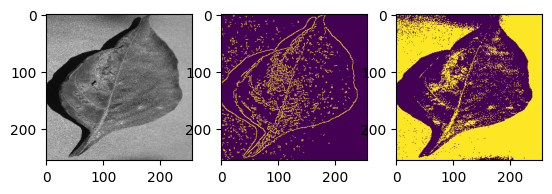

/content/drive/MyDrive/datasets/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG
Total Number of images: 20638


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

folders=os.listdir(address)
subfolder=os.path.join(address,folders[0])
img_address=os.path.join(subfolder,os.listdir(subfolder)[0])

img=cv2.imread(img_address,0)
edges=cv2.Canny(img, threshold1=150, threshold2=200)
ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
plt.subplot(131); plt.imshow(img,cmap="gray")
plt.subplot(132); plt.imshow(edges)
plt.subplot(133); plt.imshow(thresh)
plt.show()
print(img_address)


count=0
for Class in os.listdir(address):
    for fname in os.listdir(os.path.join(address,Class)):
        count+=1
print("Total Number of images:",count)

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = address  # Root folder with class subfolders
class_names = os.listdir(data_dir)  # ['class1', 'class2', ...]
num_classes=len(class_names)

# Collect file paths and labels
file_paths = []
labels = []

for class_id, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for file in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file))
        labels.append(class_id)  # Assign numerical label (0, 1, 2, ...)

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

# Split into 80% train, 20% test (adjust ratio as needed)
X_train, X_test, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)

from tensorflow.keras.utils import to_categorical
#one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(X_test.shape)
print(y_test.shape)

(4128,)
(4128, 15)


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

input_size=[224,224]

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, input_size)  # Resize for your model
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)  #batches of 32, with prefetch optimization for faster loading
test_dataset = test_dataset.map(preprocess_image).batch(32)

In [ ]:
#Define the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Input Layer (250x250 RGB images)
    Conv2D(32, (3, 3), activation='relu', input_shape=(input_size[0], input_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Reduces overfitting
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Output Layer (Softmax for multi-class classification)
    Dense(num_classes, activation='softmax')  # Replace `num_classes` with your class count
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Compile and train
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')  #Stop training early if accuracy starts to reduce

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS=10

model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS, callbacks=[early_stop])

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2942 - loss: 4.8461

KeyboardInterrupt: 

In [ ]:
#Saving checkpoint
model.save("LeafClassifier_checkpoint1.keras")

In [ ]:
from google.colab import files
files.download('LeafClassifier_checkpoint1.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Continue trianing

model.fit(train_dataset, validation_data=test_dataset,
          epochs=10,
          initial_epoch=1,
          callbacks=[early_stop])

Epoch 2/10
172/516 ━━━━━━━━━━━━━━━━━━━━ 34:47 6s/step - accuracy: 0.4683 - loss: 1.8193

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,199,279 (222.01 MB)

 Trainable params: 19,399,439 (74.00 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 38,798,880 (148.01 MB)